In [1]:
# Let's work on the problem from Quantum SI for the Computational Scientist position
# See 'prompt.txt' for the problem statement, and 'sequences.txt' for the relevant data

%load_ext autoreload
%autoreload 2
# import standard packages
import scipy.signal
import matplotlib.pyplot as plt
import sklearn.manifold 
import sklearn.cluster  
import numpy as np
import time
import math

import pandas as pd
import seaborn as sns

# import custon functions
import functions.importData as importData
import functions.randomWalks as randomWalks

In [2]:
# Let's import the data first

sequences = importData.importDataset("sequences.txt")
                                  
## and transform it to my complex base
sequencesCmplx = importData.transformStringBase(sequences)
#print(sequencesCmplx[0][0:3])

In [3]:
# Let's look at the frequency domain via the power density spectrum
# Calculate the spectra here, plot them in the next cell
sequencesTransformed = importData.transformStringBase(sequences, mappingDict = {"a":-1, "b":0,"c":1})

samplingRate = 1 # arbitrary here
spectralList = []

startTime = time.time()
for index , sequence in enumerate(sequencesCmplx):
    index+=1
    (frequencies, signal) = scipy.signal.periodogram(sequence, samplingRate, scaling='density', return_onesided = False)
    spectralList.append(signal)
    #if index %100 == 0 : print( index, time.time()-startTime)

spectralArray = np.array(spectralList)

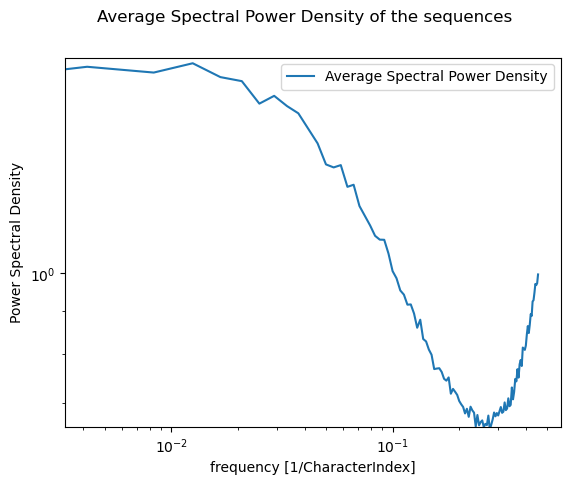

No clear peaks in the frequency spectrum. So the sequences might be in aggregate quite random indeed.


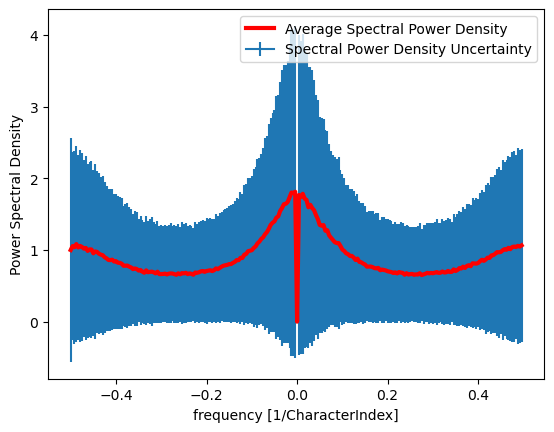

And the uncertainties on the power spectral density are on the order 100%, so at least for the ensemble, the spectral density is not a very informative quantitiy. Maybe look at a histogram of the spectral density later. But for now lets try something more promising.


In [4]:

# sort frequencies in ascending order, to avoid some plotting artifacts
frequencies_sort_index = np.argsort(frequencies)
frequencies = frequencies[frequencies_sort_index]

# sort the spectral means and standard deviation in the same way, so to not plot nonense
spectralMean = np.mean(spectralArray ,axis=0 )[frequencies_sort_index]
spectralStd  = np.std(spectralArray ,axis=0 )[frequencies_sort_index]


# make a log-log plot

fig_SPD_LogLog, axs_SPD_LogLog = plt.subplots()
fig_SPD_LogLog.suptitle('Average Spectral Power Density of the sequences')
plot_SPD_LogLog = axs_SPD_LogLog.loglog(frequencies[1:230], spectralMean[1:230], label='Average Spectral Power Density')
axs_SPD_LogLog.set_ylim([np.percentile(spectralMean,1),max(spectralMean)])
axs_SPD_LogLog.set_xlabel('frequency [1/CharacterIndex]')
axs_SPD_LogLog.set_ylabel('Power Spectral Density')
axs_SPD_LogLog.legend()

plt.show()
print("No clear peaks in the frequency spectrum. So the sequences might be in aggregate quite random indeed.")

# make a plot with unceratainties

fig_SPD_errorBar, axs_SPD_errorBar = plt.subplots()
plot_SPD_errorBar = axs_SPD_errorBar.errorbar(frequencies,spectralMean, spectralStd, zorder=1,
                                              label='Spectral Power Density Uncertainty' )
plot_SPD_mean     = axs_SPD_errorBar.plot(frequencies,spectralMean,color='r',linewidth=3 ,zorder=2,
                                         label='Average Spectral Power Density')
axs_SPD_errorBar.set_xlabel('frequency [1/CharacterIndex]')
axs_SPD_errorBar.set_ylabel('Power Spectral Density')
axs_SPD_errorBar.legend()

plt.show()
print("And the uncertainties on the power spectral density are on the order 100%, so at least for the ensemble, \
the spectral density is not a very informative quantitiy. \
Maybe look at a histogram of the spectral density later. \
But for now lets try something more promising.")

#import pdb; pdb.set_trace()


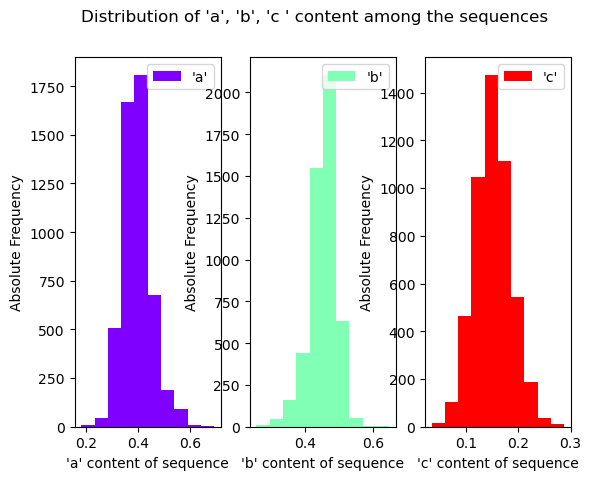

ok, the distribution of p(a), p(b), and p(c) does not look tooo different from each other, or at least somewhat normally distributed. Though also note that the c frequency seems to be lower than the a and b ones.So let's look at the transition propability distributions


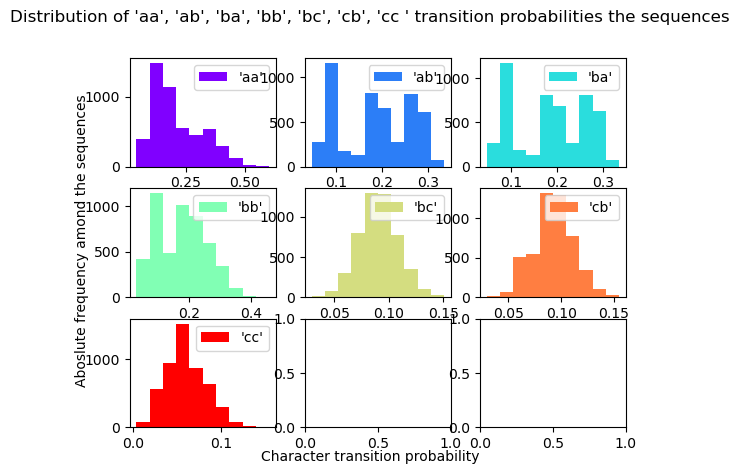

Ok, there are some peaked distributions. Particularly the 'aa', 'ab', 'bb', and 'ba' transitions.      Though more remarkable is that there are no transitions involving C and A. I hadn't realized that before.       The underlying stochastic process could still be a randon walk, just not on a ring of 'a', 'b', and 'c'      But instead on a linear segment with.      So maybe my initial idea of embedding the sequences in a vector space where a, b, and c are equidistant      is maybe not a choice that matches the underlying stochastic process.       Maybe, if we want to define a distance metric, the distance d(a,c) should be larger than d(a,b) for example. 


In [5]:
# let's investigate if the sequnces might be derived from a random walk.

# random walk over the states 'a','b', and 'c' should be defined by the 
# transition properties P(i,j) = P(i->j) , i,j \in ['a','b', and 'c']
# So let's measure those for all sequences and see what kind of distribution we find.
# If the sequences are indeed derived from random walks with different matrices of transition probabilities
# we should be able to see multiple peaks in the P(i,j) histogram.

# also measure the character frequency, while we are at it
charFreq , charFreqBasis = randomWalks.getCharacterFrequency(sequences)

# measure transition probabilities in the different strings
transFreq , transFreqBasis = randomWalks.calculateTransitionFrequencies(sequences)


fig_Hist_CharFrq, axs_Hist_CharFrq = plt.subplots(1, len(charFreqBasis))

fig_Hist_CharFrq.suptitle('Distribution of \'%s \' content among the sequences' % ('\', \''.join(charFreqBasis)))

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(charFreqBasis))))

for index, charBasis in enumerate(charFreqBasis):
    axs_Hist_CharFrq[index].hist(charFreq[:,index],label='\'%s\''%charBasis, color = next(color))
    axs_Hist_CharFrq[index].legend()
    axs_Hist_CharFrq[index].set_xlabel('\'%s\' content of sequence' %charBasis)
    axs_Hist_CharFrq[index].set_ylabel('Absolute Frequency')

plt.show() 

print( "ok, the distribution of p(a), p(b), and p(c) does not look \
tooo different from each other, \
or at least somewhat normally distributed. \
Though also note that the c frequency seems to be lower than the a and b ones.\
So let's look at the transition propability distributions")


nSubplotRows = 3
nSubplotColumns = math.ceil(len(transFreqBasis)/nSubplotRows)

fig_Hist_TransFrq, axs_Hist_TransFrq = plt.subplots(nSubplotRows, nSubplotColumns)
fig_Hist_TransFrq.suptitle('Distribution of \'%s \' transition probabilities the sequences' % ('\', \''.join(transFreqBasis)))

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(transFreqBasis))))

for index, charBasis in enumerate(transFreqBasis):
    
    #math.nSubplotRows
    
    axs_idx = [math.floor(index/nSubplotRows) , index%nSubplotColumns]
    
    #print( index, axs_idx, charBasis)
    
    #import pdb; pdb.set_trace()
    
    #axs_Hist_TransFrq = fig_Hist_TransFrq.add_subplot(nSubplotRows, nSubplotColumns, index+1)
    #plt.subplot(2, 1, 1)
    axs_Hist_TransFrq[axs_idx[0],axs_idx[1]].hist(transFreq[:,index],label='\'%s\''%charBasis, color = next(color))
    axs_Hist_TransFrq[axs_idx[0],axs_idx[1]].legend()
    #axs_Hist_TransFrq.set_xlabel('\'%s\' content of sequence' %charBasis)
    #axs_Hist_TransFrq.set_ylabel('Absolute Frequency')
    
    #xTickLabels = axs_Hist_TransFrq.get_xticklabels()
    #axs_Hist_TransFrq.set_xticklabels(xTickLabels, fontsize=20)
    #break


fig_Hist_TransFrq.text(0.5, 0.04, 'Character transition probability', ha='center')
fig_Hist_TransFrq.text(0.04, 0.5, 'Aboslute frequency amond the sequences', va='center', rotation='vertical')
    
plt.show() 

print("Ok, there are some peaked distributions. Particularly the 'aa', 'ab', 'bb', and 'ba' transitions.\
      Though more remarkable is that there are no transitions involving C and A. I hadn't realized that before. \
      The underlying stochastic process could still be a randon walk, just not on a ring of 'a', 'b', and 'c'\
      But instead on a linear segment with.\
      So maybe my initial idea of embedding the sequences in a vector space where a, b, and c are equidistant\
      is maybe not a choice that matches the underlying stochastic process. \
      Maybe, if we want to define a distance metric, the distance d(a,c) should be larger than d(a,b) for example. ")

#import pdb; pdb.set_trace()

In [6]:
# eventually we want to do some clustering on the transition probabilities
# but for now, let's see if we can make a visualtion of 
# how these probabilities might are jointly distributed
# let's try a T-distributed Stochastic Neighbor Embedding.

# We want to get TSNE embedding with 2 dimensions
n_components = 2
TSNE = sklearn.manifold.TSNE(n_components)
tsne_transFreq_result = TSNE.fit_transform(transFreq)

# do also a TSNE embedding for the transition probabilities 
# concatenated with the char frequencies

transAndCharFreq = np.concatenate((transFreq,charFreq),axis=1)

tsne_transAndCharFreq_result = TSNE.fit_transform(transFreq)





ok neat, we end up with 3 clear groupings!Let's do this again and include the character frequencies in addition to the transition probabilities, and then do the the clustering in the P(i->j), P(i) space to get some information on what these cluster might mean


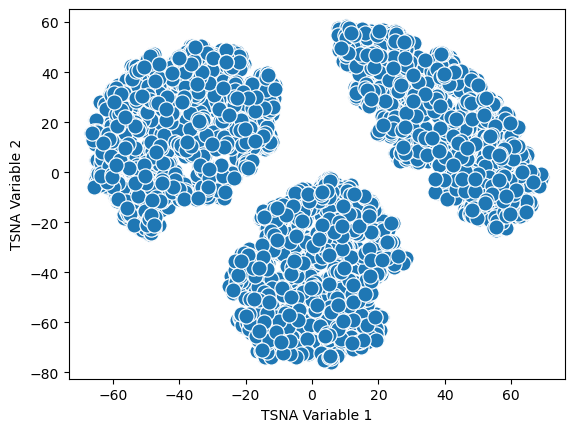

In [7]:
# process our TSNE embedding

tsne_result_df = pd.DataFrame({'TSNA Variable 1': tsne_transFreq_result[:,0],
                               'TSNA Variable 2': tsne_transFreq_result[:,1],
                              })#'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='TSNA Variable 1', y='TSNA Variable 2', data=tsne_result_df, ax=ax,s=120)
#lim = (tsne_transFreq_result.min()-5, tsne_transFreq_result.max()+5)
#ax.set_xlim(lim)
#ax.set_ylim(lim)
#ax.set_aspect('equal')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

print( "ok neat, we end up with 3 clear groupings!\
Let's do this again and include the character frequencies in addition to the transition probabilities, \
and then do the the clustering in the P(i->j), P(i) space \
to get some information on what these cluster might mean")

Not much change w.r.t. the prior plot, but that is ok!


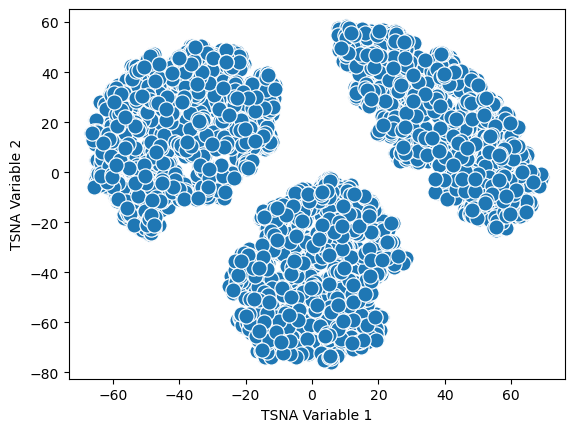

In [8]:
# process our TSNE embedding

tsne_result_df = pd.DataFrame({'TSNA Variable 1': tsne_transAndCharFreq_result[:,0],
                               'TSNA Variable 2': tsne_transAndCharFreq_result[:,1],
                              })#'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='TSNA Variable 1', y='TSNA Variable 2', data=tsne_result_df, ax=ax,s=120)
#lim = (tsne_transFreq_result.min()-5, tsne_transFreq_result.max()+5)
#ax.set_xlim(lim)
#ax.set_ylim(lim)
#ax.set_aspect('equal')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

print("Not much change w.r.t. the prior plot, but that is ok!")

In [9]:
# And now do othe embedding with the actual transition probabilities, not the transition frequencies

transitionProbabilities = randomWalks.getTransitionProbabilities(transFreq , transFreqBasis, charFreq , charFreqBasis)

# We want to get TSNE embedding with 2 dimensions
n_components = 2
TSNE = sklearn.manifold.TSNE(n_components)
tsne_transProb_result = TSNE.fit_transform(transitionProbabilities)




ok, things hold up!


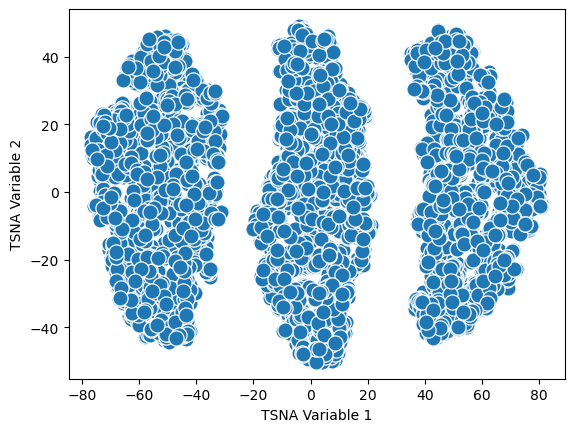

In [10]:
# process our TSNE embedding

tsne_result_df = pd.DataFrame({'TSNA Variable 1': tsne_transProb_result[:,0],
                               'TSNA Variable 2': tsne_transProb_result[:,1],
                              })#'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='TSNA Variable 1', y='TSNA Variable 2', data=tsne_result_df, ax=ax,s=120)
#lim = (tsne_transFreq_result.min()-5, tsne_transFreq_result.max()+5)
#ax.set_xlim(lim)
#ax.set_ylim(lim)
#ax.set_aspect('equal')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

print("ok, things hold up!")

ok neat, we end up with 3 clear groupings!Let's do this again and include the character frequencies in addition to the transition probabilities, and then do the the clustering in the P(i->j), P(i) space to get some information on what these cluster might mean


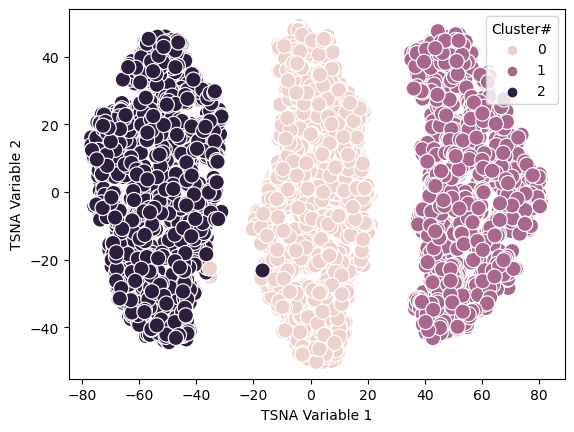

In [11]:
# let's try some clustering

kmeans = sklearn.cluster.KMeans(init="k-means++", n_clusters=3, n_init=4, random_state=0)


kmeans.fit(transitionProbabilities)

kmeans_labels = kmeans.predict(transitionProbabilities)


#transFreq
#transFreqBasis


kmeans_uniqueLAbels, transProb_mean_byLabel, transProb_std_byLabel  = \
randomWalks.calculateAverageTransitionProbabilitiesBasedOnClusterLabel(kmeans_labels,transitionProbabilities)


#import pdb; pdb.set_trace()


tsne_result_df = pd.DataFrame({'TSNA Variable 1': tsne_transProb_result[:,0],
                               'TSNA Variable 2': tsne_transProb_result[:,1],
                              'Cluster#': kmeans_labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='TSNA Variable 1', y='TSNA Variable 2', hue='Cluster#', data=tsne_result_df, ax=ax,s=120)
#lim = (tsne_transFreq_result.min()-5, tsne_transFreq_result.max()+5)
#ax.set_xlim(lim)
#ax.set_ylim(lim)
#ax.set_aspect('equal')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

print( "ok neat, we end up with 3 clear groupings!\
Let's do this again and include the character frequencies in addition to the transition probabilities, \
and then do the the clustering in the P(i->j), P(i) space \
to get some information on what these cluster might mean")

In [12]:
print(" ok so we have 3 random walks that are given by their transition probabilities ")


for clusterIndex in range(len(transProb_mean_byLabel)) : 
    print("Cluster %i"%clusterIndex)
    
    for index, transition in enumerate(transFreqBasis):
        
 
        print(transition + ": %.2f ± %.2f" %(transProb_mean_byLabel[clusterIndex][index], transProb_std_byLabel[clusterIndex][index]))

#transProb_mean_byLabel, 
#transProb_std_byLabel

 ok so we have 3 random walks that are given by their transition probabilities 
Cluster 0
aa: 0.52 ± 0.04
ab: 0.48 ± 0.03
ba: 0.40 ± 0.05
bb: 0.38 ± 0.05
bc: 0.22 ± 0.05
cb: 0.57 ± 0.09
cc: 0.43 ± 0.08
Cluster 1
aa: 0.82 ± 0.01
ab: 0.19 ± 0.01
ba: 0.20 ± 0.02
bb: 0.60 ± 0.03
bc: 0.20 ± 0.01
cb: 0.64 ± 0.11
cc: 0.36 ± 0.11
Cluster 2
aa: 0.29 ± 0.04
ab: 0.72 ± 0.04
ba: 0.61 ± 0.03
bb: 0.19 ± 0.03
bc: 0.20 ± 0.04
cb: 0.61 ± 0.10
cc: 0.38 ± 0.11
